# Implementing a Multiclass Classifier
   
**D3APL – Aplicações em Ciência de dados**

Especialização em Ciência de Dados - IFSP Campinas

Alunos
- Daniel Vargas Shimamoto
- Diego Machado de Assis

## Set up

### Imports

In [1]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

### Graph styles

In [2]:
sns.set_theme(
    style='white',
    rc={
        'axes.titlesize': 16,
        'axes.labelsize': 12,
        'axes.spines.top': False,
        'axes.spines.right': False,
    }
)

## Implementation

In [3]:
#%%writefile module/grupo5.py
from typing import Tuple

import numpy as np
from numpy import ndarray

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y


class LogisticRegression(ClassifierMixin, BaseEstimator):
    """
    Logistic Regression multiclass classifier using an One-Vs-Rest strategy.
    
    Parameters
    ----------
    learning_rate : float, default=0.01
        Learning rate.

    n_epochs : int, default=(1000 | 2 * minibatch_size | 2)
        Number of epochs for training (convergence stop).
        If `optimizer` == 'batch' (default), n_epochs defaults to 1000.
        If `optimizer` == 'minibatch', the default value is 2 * minibatch_size
        If `optimizer` == 'stochastic', the default value is reduced to 2.

    alpha : float, default=0.0001
        Constant that multiplies the regularization term.
        Use 0 to ignore regularization (standard Logistic Regression).
        
    optimizer : {'batch', 'minibatch', 'stochastic'}, defatult='batch'
        Gradient descent optimizer strategy
        
    minibatch_size : int, default=100
        Minibatch size when optimizer` == 'minibatch'

    verbose : int, default=0
        The verbosity level, if non zero, progress messages are printed
        and decision boundary is plot

    random_state : int, default=42
        Seed used for generating random numbers.
        
    Attributes
    ----------
    classes_ : ndarray of shape (n_classes, )
        A list of class labels known to the classifier.
    
    coef_ : ndarray of shape (1, n_features) or (n_classes, n_features)
        Coefficient of the features in the decision function.        
        `coef_` is of shape (1, n_features) when the given problem is binary.
        
    intercept_ : ndarray of shape (1,) or (n_classes,)
        Intercept (a.k.a. bias) added to the decision function.
        `intercept_` is of shape (1,) when the given problem is binary.
        
    multilabel_ : bool
        Whether this is a multilabel classifier.
        
    n_classes_ : int
        Number of classes known to the classifier.
        
    n_features_in_ : int
        Number of features seen during `fit`.
    """
    
    def __init__(
        self,
        learning_rate: float = 0.01,
        n_epochs: int = None,
        alpha: float = 0.0001,
        optimizer: str = "batch",
        minibatch_size: int = 100,
        verbose: int = 0,
        random_state: int = 42
    ):

        assert isinstance(learning_rate, (float, int)) and (learning_rate > 0), \
        f'Learning rate must be a `float` > 0.0. Passed: "{learning_rate}"'
        
        assert (n_epochs is None) or (isinstance(n_epochs, int) and (n_epochs > 0)), \
        f'Number of epochs must be an `int` > 0. Passed: "{n_epochs}"'
        
        assert isinstance(alpha, (float, int)) and (alpha >= 0), \
        f'Alpha must be a `float` >= 0.0. Passed: "{alpha}"'
        
        assert optimizer in ['batch', 'minibatch', 'stochastic'], \
        f'Optimizer must be in {"batch", "minibatch", "stochastic"}. Passed: "{optimizer}"'
        
        assert (optimizer != 'minibatch') or (isinstance(minibatch_size, int) and (minibatch_size > 0)), \
        f'Minibatch size must be an `int` > 0. Passed: "{minibatch_size}"'
        
        if n_epochs is None:
            if optimizer == 'minibatch':
                n_epochs = 2 * minibatch_size
            elif optimizer == 'stochastic':
                n_epochs = 2
            else:
                n_epochs = 1000
        
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.alpha = alpha
        self.optimizer = optimizer
        self.minibatch_size = minibatch_size
        self.verbose = verbose
        self.random_state = random_state
        
        # parameters to be trained/learned
        self.__w = None  # weight array
        self.__b = None  # bias
        
        self.__classes = None
    
    
    # a special method used to represent a class object as a string, called with print() or str()
    def __str__(self):
        msg = (
            "Multiclass Logistic Regressor Instance\n\n"
            f"Learning rate: {self.learning_rate}\n"
            f"Number of epochs: {self.n_epochs}\n"
            f"Regularization constant (alpha): {self.alpha}\n"
            f"Optimizer (optimizer): {self.optimizer}\n"
            f"{f'Minibatch size: {self.minibatch_size}' if self.optimizer == 'minibatch' else ''}\n"
            f"Verbose: {self.verbose}\n"
            f"Random state: {self.random_state}\n\n"
            f"Trained?: {self.is_fitted()}"
        )

        return msg
    
    @property
    def classes_(self) -> ndarray:
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__classes
    
    
    @property
    def n_classes_(self) -> int:
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return len(self.__classes)
    
    
    @property
    def multilabel_(self) -> int:
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.n_classes_ > 2
    
    
    @property
    def coef_(self) -> ndarray:
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__w
    

    @property
    def intercept_(self) -> ndarray:
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__b
        
    
    @property
    def n_features_in_(self) -> int:
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__w.shape[1]
    
    
    def is_fitted(self) -> bool:
        return self.__w is not None
    
    
    def __sigmoid(self, z: ndarray) -> ndarray:
        return 1 / (1 + np.e ** (-z))
    
        
    def __shuffle(self, X: ndarray, y: ndarray) -> Tuple[ndarray, ndarray]:
        """
        Return a random permutation of features and labels
        """
        p = np.random.permutation(len(y))
        return X[p], y[p]
    
    
    def __log_loss(self, y: ndarray, p_hat: ndarray, eps: float = 1e-15) -> float:
        """
        Return the log loss for a given estimation and ground-truth (true labels).
        
        log is undefined for 0. Consequently, the log loss is undefined for
        `p_hat=0` (because of log(p_hat)) and `p_hat=1` (because of ln(1 - p_hat)).
        
        To overcome that, we clipped the probabilities to max(eps, min(1 - eps, p_hat)),
        where `eps` is a tiny constant. 

        Parameters
        ----------
        y : ndarray, of shape (n_samples,)
            True labels of input samples.
            
        p_hat : ndarray
            Estimated probabilities of input samples.
            
        eps : float, default=1e-15
            Epsilon term used to avoid undefined log loss at 0 and 1.
        
        Returns
        -------
        log_loss : float
            Computed log loss.
        """
        
        p_hat_eps = np.maximum(eps, np.minimum(1 - eps, p_hat))
        
        losses = -(y * np.log(p_hat_eps) + (1 - y) * np.log(1 - p_hat_eps))
        log_loss = losses.mean()
        
        return log_loss
    
    
    def __gradient(
        self,
        X: ndarray,
        y: ndarray,
        p_hat: ndarray,
        w: ndarray,
        alpha: float
    ) -> Tuple[ndarray, float]:
        '''
        Compute the gradient vector for the log loss with regards to the weights and bias.
        
        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        p_hat : ndarray of shape (n_samples,)
            Estimated probabilities.
        w : ndarray of shape (n_features,)
            Weight array.
        alpha : float
            Reguralization constant.
        
        Returns
        -------
        Tuple[ndarray, float]: 
            Tuple with:
            - a numpy array of shape (n_features,) containing the partial derivatives w.r.t. the weights; and
            - a float representing the partial derivative w.r.t. the bias.
        '''
        
        n_samples = len(X)
        
        regularization = alpha * w
        
        error = p_hat - y
        grad_w = (np.dot(error, X) / n_samples) + regularization
        grad_b = error.mean()
        
        return grad_w, grad_b

    
    def __plot_boundaries(self, X: ndarray, y: ndarray, weights: ndarray, biases: ndarray, verbose: int):      
        fig = plt.figure(figsize=(16,8), tight_layout=True)
        gs = GridSpec(3, 3, figure=fig)
            
        ax1 = fig.add_subplot(gs[:, :-1])
        ax2 = fig.add_subplot(gs[0, -1])
        ax3 = fig.add_subplot(gs[1, -1])
        ax4 = fig.add_subplot(gs[2, -1])
            
        w_lines = weights[:-1:verbose] + [ weights[-1] ]
        b_lines = biases[:-1:verbose] + [ biases[-1] ]
        colors = sns.color_palette("crest", n_colors=len(w_lines))
        
        for i, (w1, w2), b in zip(range(len(w_lines)), w_lines, b_lines):
            x1_decision_line = np.array([X[:, 0].min(), X[:, 0].max()])
            x2_decision_line = -(b + (w1 * x1_decision_line)) / w2
            sns.lineplot(x=x1_decision_line, y=x2_decision_line, color=colors[i], ax=ax1)
                
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax1, zorder=99)
                
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_xlim(X[:, 0].min(), X[:, 0].max())
        ax1.set_ylim(X[:, 1].min(), X[:, 1].max())
        ax1.set_title('Updates of Decision Boundary on Training Samples')
            
        weights = np.array(weights)
        biases = np.array(biases)
        sns.lineplot(x=weights[:, 0], y=biases, ax=ax2)
        ax2.set(title="Evolution of w1 x b", xlabel="w1", ylabel="b")
            
        sns.lineplot(x=weights[:, 1], y=biases, ax=ax3)
        ax3.set(title="Evolution of w2 x b", xlabel="w2", ylabel="b")
            
        sns.lineplot(x=weights[:, 0], y=weights[:, 1], ax=ax4)
        ax4.set(title="Evolution of w1 x w2", xlabel="w1", ylabel="w2")
            
        plt.show()

    
    def __binary_fit(self, X: ndarray, y: ndarray):
        '''
        Train a Binary Logistic Regression classifier.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,)
            Target (true) labels.
            
        Returns
        -------
        w, b: Tuple[ndarray, float]
            Weights (n_features,) and bias learned from the fit method
        '''

        n_samples, n_features = X.shape

        ### PARAMETER INITIALIZATION
        # return values from the "standard normal" distribution.
        w = np.random.randn(n_features)
        b = np.random.randn()
        
        # values of each iteration
        losses = []
        weights = [w]
        biases = [b]
        
        if self.optimizer == 'stochastic':
            batch_size = 1
        elif self.optimizer == 'minibatch':
            batch_size = self.minibatch_size
        else:
            batch_size = n_samples
        
        # LEARNING ITERATIONS
        batch_range = range(0, n_samples, batch_size)
        total_iterations = self.n_epochs * len(batch_range)
        n_iteration = 0
        
        for epoch in range(self.n_epochs):
            X, y = self.__shuffle(X, y)
            for i in batch_range:
                X_b = X[i:i + batch_size]
                y_b = y[i:i + batch_size]
                
                ### ESTIMATION (FORWARD PASS)
                z = np.dot(X_b, w) + b
                p_hat = self.__sigmoid(z)
            
                ### LOSS
                J = self.__log_loss(y_b, p_hat)

                losses.append(J)
                
                ### GRADIENT DESCENT UPDATES (BACKWARD PASS)
                grad_w, grad_b = self.__gradient(X_b, y_b, p_hat, w, self.alpha)
                w = w - self.learning_rate * grad_w
                b = b - self.learning_rate * grad_b
                
                weights.append(w)
                biases.append(b)
                
                n_iteration += 1
                if self.verbose > 0 and ((n_iteration == 1) or (n_iteration % self.verbose == 0)) :
                    print(f'[INFO] iteration={n_iteration}/{total_iterations}, loss={J:.7f}')
                                    
        if self.verbose > 0:
            losses = np.array(losses)
            print(f'\nFinal loss: {losses[-1]}')
            print(f'\nMean loss: {losses.mean()} +- {losses.std()}')
            self.__plot_boundaries(X, y, weights, biases, self.verbose)
            
        return weights[-1], biases[-1]
            
    
    def fit(self, X: ndarray, y: ndarray):
        '''
        Train a Binary or Multiclass Logistic Regression classifier.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,)
            Target (true) labels.
            
        Returns
        -------
        self : object
            Returns self.
        '''          

        # Validate X and y
        X, y = check_X_y(X, y)

        np.random.seed(self.random_state)
        
        self.__classes = np.unique(y)
        
        # "Special" case when we have only 2 classes (train just one classifier, not 2)
        classes = self.__classes if len(self.__classes) > 2 else self.__classes[-1:]
        
        ### ONE-VS-REST
        
        # w: (n_classes, n_features) if multiclass OR (1, n_features) if binary
        # b: (n_classes,) if multiclass OR (1,) if binary
        w, b = [], []
        
        # For each class, train a binary classifier
        for label in classes:
            # The current label is set to the positive class (1)
            # and all the others, to the negative one (0).
            y_label = np.array([1 if l == label else 0 for l in y])
            
            # Tain a binary classifier considering the current binary labels
            if self.verbose and len(self.__classes) > 2:
                print(f'### TRAINING FOR CLASS "{label}" ###')
            w_label, b_label = self.__binary_fit(X, y_label)
            
            w.append(w_label)
            b.append(b_label)
            
        self.__w = np.array(w)
        self.__b = np.array(b)
            
        return self
    
    
    def predict_proba(self, X: ndarray) -> ndarray:
        '''
        Estimate the probability for each class of input samples.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples, n_classes)
            The estimated probabilities for each class of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'

        z = np.dot(X, self.__w.T) + self.__b
        p_hat = self.__sigmoid(z)
        
        return p_hat  
        
        
    def predict(self, X: ndarray) -> ndarray:
        '''
        Predict the labels for input samples.
        
        If a binary problem, thresholding at probability >= 0.5 to positive class.
        If a multiclass problem, return the class with max probability

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted labels of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'
        
        p_hat = self.predict_proba(X)
        
        y_hat = np.argmax(p_hat, axis=1) if self.multilabel_ else (p_hat[:, 0] >= 0.5).astype(int)
        
        return self.classes_[y_hat]

## Testing

### Creating an instance

In [4]:
clf = LogisticRegression()
print(clf)

Multiclass Logistic Regressor Instance

Learning rate: 0.01
Number of epochs: 1000
Regularization constant (alpha): 0.0001
Optimizer (optimizer): batch

Verbose: 0
Random state: 42

Trained?: False


In [5]:
clf.get_params()

{'alpha': 0.0001,
 'learning_rate': 0.01,
 'minibatch_size': 100,
 'n_epochs': 1000,
 'optimizer': 'batch',
 'random_state': 42,
 'verbose': 0}

#### Parameters validation

In [6]:
invalid_parameters = [
    { 'learning_rate': None },
    { 'learning_rate': 'error_rate' },
    { 'learning_rate': [0, 1, 2] },
    { 'n_epochs': 0.1 },
    { 'n_epochs': 'error_epochs' },
    { 'alpha': None },
    { 'alpha': 'error_alpha' },
    { 'optimizer': None },
    { 'optimizer': 42 },
    { 'optimizer': 'error_optimizer' },
    { 'optimizer': 'minibatch', 'minibatch_size': None },
    { 'optimizer': 'minibatch', 'minibatch_size': 0.1 },
    { 'optimizer': 'minibatch', 'minibatch_size': 'error_minibatch_size' },
]

In [7]:
for params in invalid_parameters:
    try:
        LogisticRegression(**params)
        print('*** This should never be printed ***')
    except AssertionError as e:
        print(f'Error: {e}')

Error: Learning rate must be a `float` > 0.0. Passed: "None"
Error: Learning rate must be a `float` > 0.0. Passed: "error_rate"
Error: Learning rate must be a `float` > 0.0. Passed: "[0, 1, 2]"
Error: Number of epochs must be an `int` > 0. Passed: "0.1"
Error: Number of epochs must be an `int` > 0. Passed: "error_epochs"
Error: Alpha must be a `float` >= 0.0. Passed: "None"
Error: Alpha must be a `float` >= 0.0. Passed: "error_alpha"
Error: Optimizer must be in ('batch', 'minibatch', 'stochastic'). Passed: "None"
Error: Optimizer must be in ('batch', 'minibatch', 'stochastic'). Passed: "42"
Error: Optimizer must be in ('batch', 'minibatch', 'stochastic'). Passed: "error_optimizer"
Error: Minibatch size must be an `int` > 0. Passed: "None"
Error: Minibatch size must be an `int` > 0. Passed: "0.1"
Error: Minibatch size must be an `int` > 0. Passed: "error_minibatch_size"


#### Testing `n_epochs` dependency of `optimizer`

In [8]:
epochs_per_parameters = [
    ({ }, 1000),
    ({ 'optimizer': 'batch' }, 1000),
    ({ 'optimizer': 'minibatch' }, 200), #minibatch_size = 100
    ({ 'optimizer': 'stochastic' }, 2),
    ({ 'n_epochs': 9999 }, 9999),
    ({ 'n_epochs': 9999, 'optimizer': 'batch' }, 9999),
    ({ 'n_epochs': 9999, 'optimizer': 'minibatch' }, 9999),
    ({ 'n_epochs': 9999, 'optimizer': 'stochastic' }, 9999),
    ({ 'n_epochs': 9999, 'optimizer': 'minibatch', 'minibatch_size': 300 }, 9999),
    ({ 'optimizer': 'minibatch', 'minibatch_size': 300 }, 600), # = 2 * minibatch_size
    ({ 'minibatch_size': 300 }, 1000),
    ({ 'optimizer': 'stochastic', 'minibatch_size': 300 }, 2)
]

In [9]:
for params, epochs in epochs_per_parameters:
    clf = LogisticRegression(**params)
    n_epochs = clf.get_params()['n_epochs']
    assert n_epochs == epochs, f'Epochs should be "{epochs}", got "{n_epochs}". Params: {params}'

### Fitting a multiclass problem

#### Creating fake data

In [10]:
X, y = make_blobs(n_samples=2000, n_features=2, centers=4, cluster_std=2.5, random_state=42)

y = np.array([f'Class {c + 1}' for c in y])

labels = np.sort(np.unique(y))

print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')
print(f'Labels: {labels}')

X.shape: (2000, 2)
y.shape: (2000,)
Labels: ['Class 1' 'Class 2' 'Class 3' 'Class 4']


In [11]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (1600, 2)
y_train.shape = (1600,)
X_test.shape = (400, 2)
y_test.shape = (400,)


In [12]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

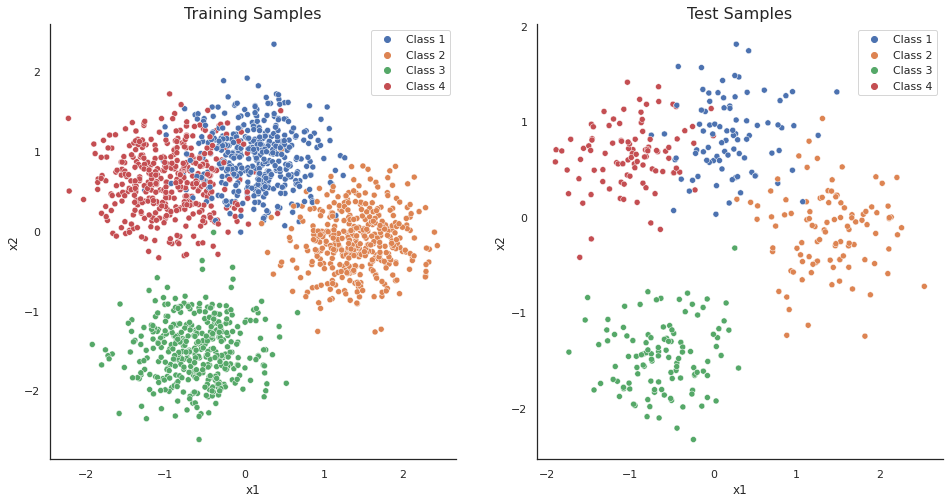

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, hue_order=labels, ax=ax[0])
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, hue_order=labels, ax=ax[1])

ax[0].set(xlabel='x1', ylabel='x2', title='Training Samples')
ax[1].set(xlabel='x1', ylabel='x2', title='Test Samples')

plt.show()

#### Using batch gradient descent

### TRAINING FOR CLASS "Class 1" ###
[INFO] iteration=1/1000, loss=0.9442613
[INFO] iteration=100/1000, loss=0.7632929
[INFO] iteration=200/1000, loss=0.6469922
[INFO] iteration=300/1000, loss=0.5730787
[INFO] iteration=400/1000, loss=0.5246645
[INFO] iteration=500/1000, loss=0.4916119
[INFO] iteration=600/1000, loss=0.4680386
[INFO] iteration=700/1000, loss=0.4505123
[INFO] iteration=800/1000, loss=0.4369857
[INFO] iteration=900/1000, loss=0.4262018
[INFO] iteration=1000/1000, loss=0.4173642

Final loss: 0.4173641525795322

Mean loss: 0.5442572223688732 +- 0.13254789888591462


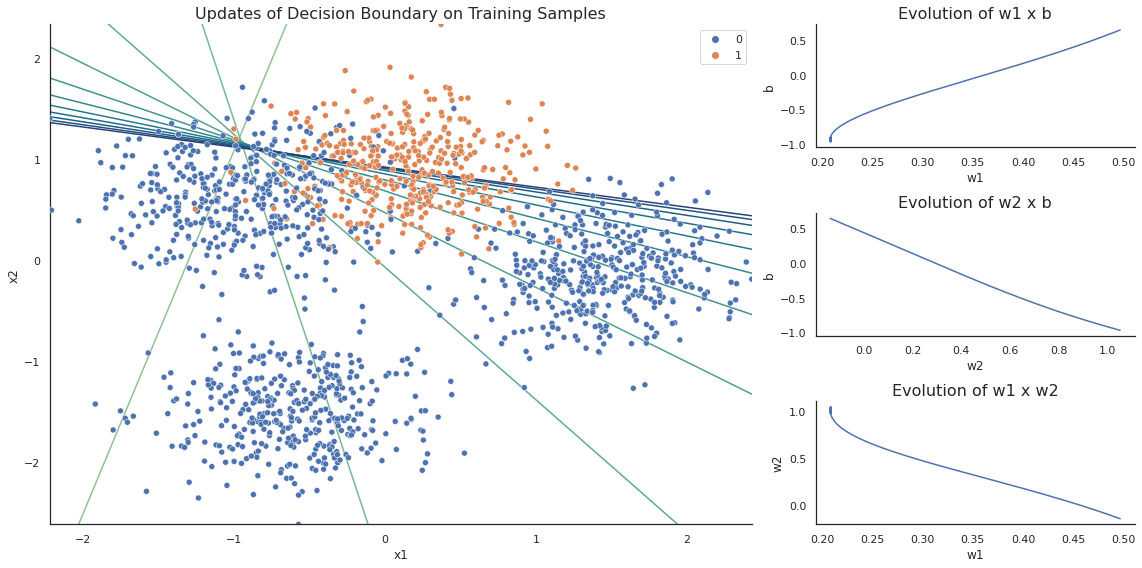

### TRAINING FOR CLASS "Class 2" ###
[INFO] iteration=1/1000, loss=1.5075574
[INFO] iteration=100/1000, loss=1.1901472
[INFO] iteration=200/1000, loss=0.9320680
[INFO] iteration=300/1000, loss=0.7334688
[INFO] iteration=400/1000, loss=0.5849529
[INFO] iteration=500/1000, loss=0.4758267
[INFO] iteration=600/1000, loss=0.3963720
[INFO] iteration=700/1000, loss=0.3385985
[INFO] iteration=800/1000, loss=0.2963429
[INFO] iteration=900/1000, loss=0.2650660
[INFO] iteration=1000/1000, loss=0.2415304

Final loss: 0.24153040426203698

Mean loss: 0.6055242609584953 +- 0.3503256604224704


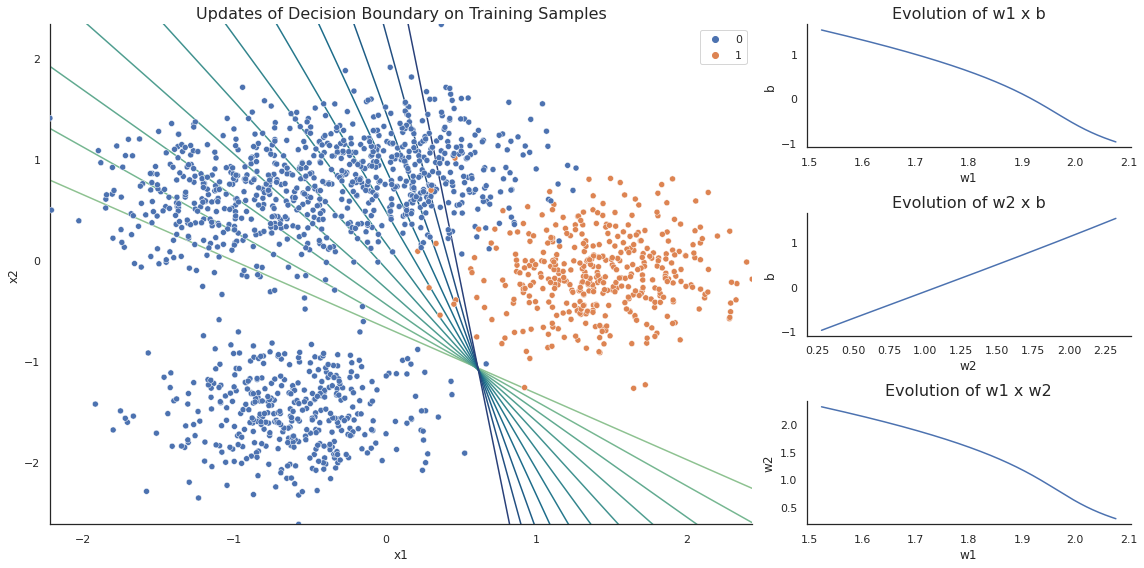

### TRAINING FOR CLASS "Class 3" ###
[INFO] iteration=1/1000, loss=0.7067218
[INFO] iteration=100/1000, loss=0.5342552
[INFO] iteration=200/1000, loss=0.4136152
[INFO] iteration=300/1000, loss=0.3326938
[INFO] iteration=400/1000, loss=0.2781912
[INFO] iteration=500/1000, loss=0.2404054
[INFO] iteration=600/1000, loss=0.2131666
[INFO] iteration=700/1000, loss=0.1927427
[INFO] iteration=800/1000, loss=0.1768772
[INFO] iteration=900/1000, loss=0.1641742
[INFO] iteration=1000/1000, loss=0.1537428

Final loss: 0.15374284813034367

Mean loss: 0.295828564983265 +- 0.14309580602629254


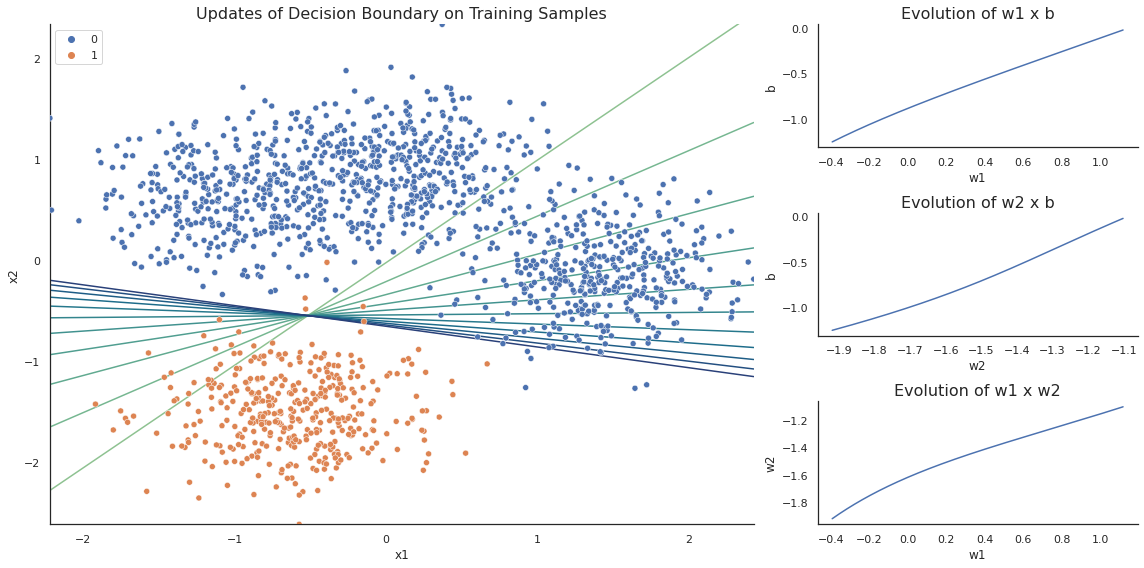

### TRAINING FOR CLASS "Class 4" ###
[INFO] iteration=1/1000, loss=0.9549242
[INFO] iteration=100/1000, loss=0.7431921
[INFO] iteration=200/1000, loss=0.6079779
[INFO] iteration=300/1000, loss=0.5219649
[INFO] iteration=400/1000, loss=0.4652097
[INFO] iteration=500/1000, loss=0.4260211
[INFO] iteration=600/1000, loss=0.3977185
[INFO] iteration=700/1000, loss=0.3764259
[INFO] iteration=800/1000, loss=0.3598265
[INFO] iteration=900/1000, loss=0.3464875
[INFO] iteration=1000/1000, loss=0.3354920

Final loss: 0.3354920375187082

Mean loss: 0.4867013676137136 +- 0.15563693954709829


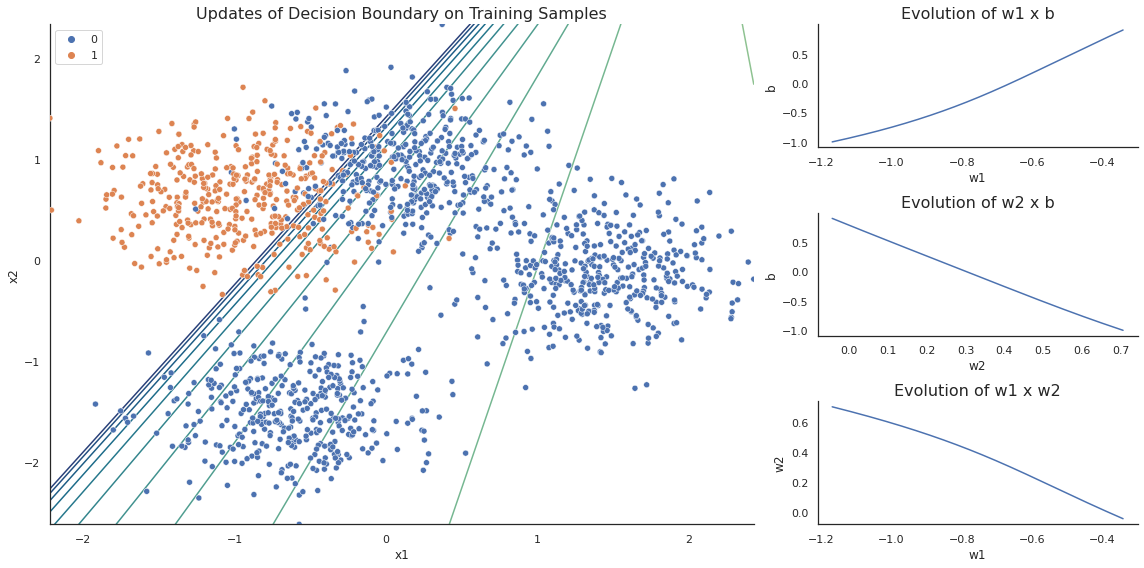

LogisticRegression(n_epochs=1000, verbose=100)

In [14]:
clf = LogisticRegression(verbose=100)
clf.fit(X_train, y_train)

In [15]:
print(f"""
Fitted parameters:
==================
  - # of classes [clf.n_classes_]: {clf.n_classes_}
  - Classes [clf.classes_]: {clf.classes_}
  - Multilabel? [clf.multilabel_]: {clf.multilabel_}
  - # of features [clf.n_features_in_]: {clf.n_features_in_}
  
  - Shape of biases array (n_classes,): {clf.intercept_.shape}
  - Biases array [clf.intercept_]: {clf.intercept_}
  
  - Shape of weights matrix (n_classes, n_features): {clf.coef_.shape}
  - Weights matrix [clf.coef_]:
{clf.coef_}
""")


Fitted parameters:
  - # of classes [clf.n_classes_]: 4
  - Classes [clf.classes_]: ['Class 1' 'Class 2' 'Class 3' 'Class 4']
  - Multilabel? [clf.multilabel_]: True
  - # of features [clf.n_features_in_]: 2
  
  - Shape of biases array (n_classes,): (4,)
  - Biases array [clf.intercept_]: [-0.97124878 -0.97412276 -1.25142328 -1.00134748]
  
  - Shape of weights matrix (n_classes, n_features): (4, 2)
  - Weights matrix [clf.coef_]:
[[ 0.20841881  1.051185  ]
 [ 2.07620259  0.28179897]
 [-0.39325803 -1.91929482]
 [-1.16886917  0.7056725 ]]



#### Using Minibatch gradient descent

### TRAINING FOR CLASS "Class 1" ###
[INFO] iteration=1/3200, loss=0.9415025
[INFO] iteration=100/3200, loss=0.7398602
[INFO] iteration=200/3200, loss=0.6405701
[INFO] iteration=300/3200, loss=0.5492555
[INFO] iteration=400/3200, loss=0.5076711
[INFO] iteration=500/3200, loss=0.4875319
[INFO] iteration=600/3200, loss=0.4823026
[INFO] iteration=700/3200, loss=0.4554104
[INFO] iteration=800/3200, loss=0.4487266
[INFO] iteration=900/3200, loss=0.4156672
[INFO] iteration=1000/3200, loss=0.4181893
[INFO] iteration=1100/3200, loss=0.4045405
[INFO] iteration=1200/3200, loss=0.3846339
[INFO] iteration=1300/3200, loss=0.4120297
[INFO] iteration=1400/3200, loss=0.3883862
[INFO] iteration=1500/3200, loss=0.3970294
[INFO] iteration=1600/3200, loss=0.3357374
[INFO] iteration=1700/3200, loss=0.3625753
[INFO] iteration=1800/3200, loss=0.3769859
[INFO] iteration=1900/3200, loss=0.3761500
[INFO] iteration=2000/3200, loss=0.3399367
[INFO] iteration=2100/3200, loss=0.4300535
[INFO] iteration=2200/3200, l

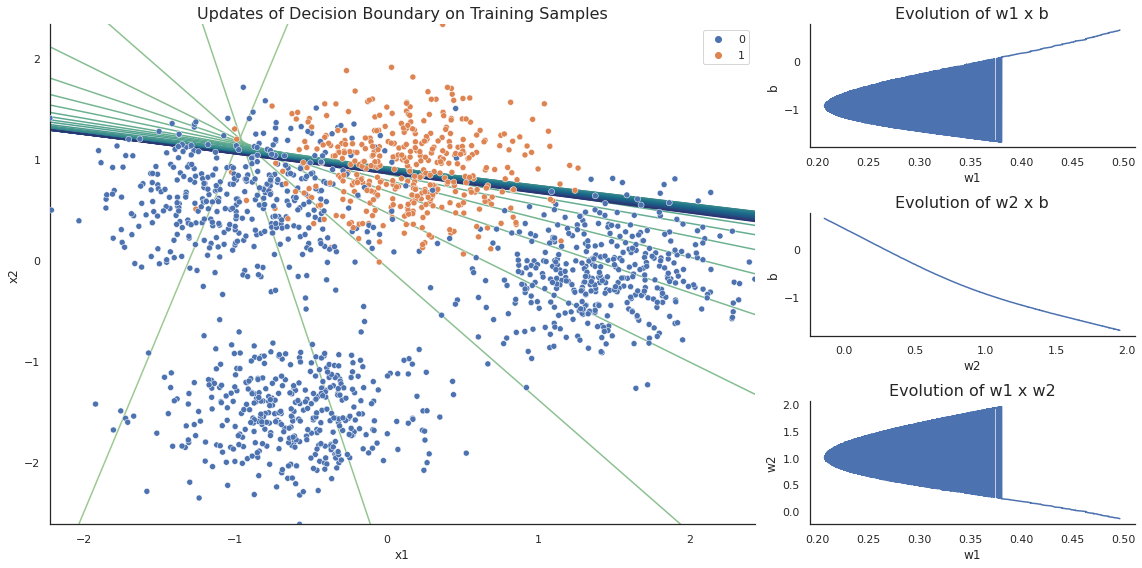

### TRAINING FOR CLASS "Class 2" ###
[INFO] iteration=1/3200, loss=0.2963436
[INFO] iteration=100/3200, loss=0.2630952
[INFO] iteration=200/3200, loss=0.2374349
[INFO] iteration=300/3200, loss=0.2192489
[INFO] iteration=400/3200, loss=0.1954531
[INFO] iteration=500/3200, loss=0.2222494
[INFO] iteration=600/3200, loss=0.2024007
[INFO] iteration=700/3200, loss=0.1876894
[INFO] iteration=800/3200, loss=0.1693371
[INFO] iteration=900/3200, loss=0.1752901
[INFO] iteration=1000/3200, loss=0.1962677
[INFO] iteration=1100/3200, loss=0.1531786
[INFO] iteration=1200/3200, loss=0.1257649
[INFO] iteration=1300/3200, loss=0.1331767
[INFO] iteration=1400/3200, loss=0.1136876
[INFO] iteration=1500/3200, loss=0.1296668
[INFO] iteration=1600/3200, loss=0.1529460
[INFO] iteration=1700/3200, loss=0.1587597
[INFO] iteration=1800/3200, loss=0.1184553
[INFO] iteration=1900/3200, loss=0.1432177
[INFO] iteration=2000/3200, loss=0.1300165
[INFO] iteration=2100/3200, loss=0.0995393
[INFO] iteration=2200/3200, l

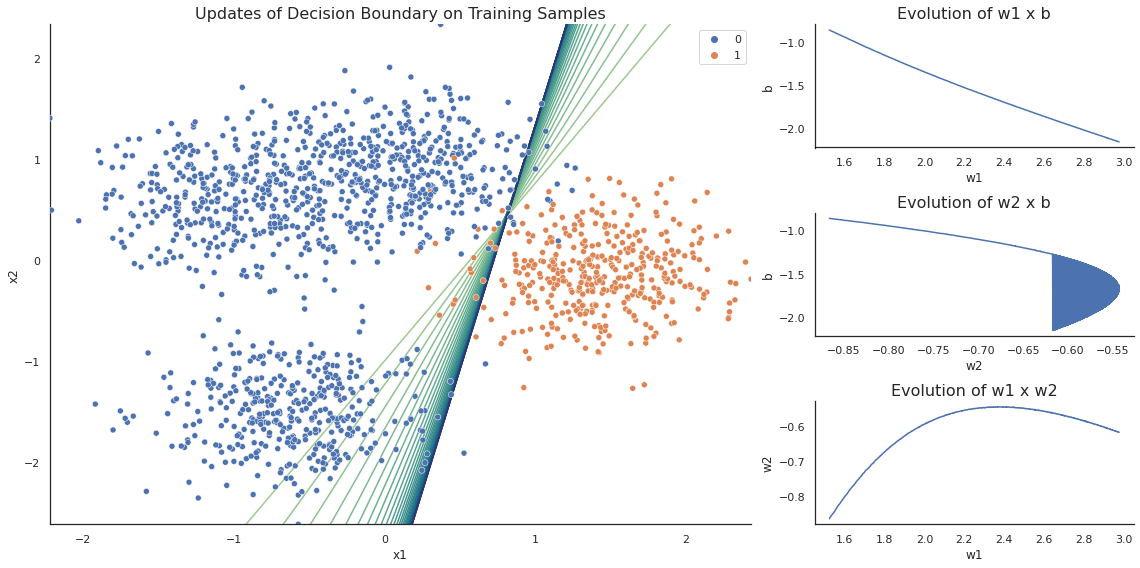

### TRAINING FOR CLASS "Class 3" ###
[INFO] iteration=1/3200, loss=1.2922212
[INFO] iteration=100/3200, loss=0.8820255
[INFO] iteration=200/3200, loss=0.6782500
[INFO] iteration=300/3200, loss=0.5138018
[INFO] iteration=400/3200, loss=0.4067902
[INFO] iteration=500/3200, loss=0.3328064
[INFO] iteration=600/3200, loss=0.2858153
[INFO] iteration=700/3200, loss=0.2410254
[INFO] iteration=800/3200, loss=0.2134403
[INFO] iteration=900/3200, loss=0.2049881
[INFO] iteration=1000/3200, loss=0.1835139
[INFO] iteration=1100/3200, loss=0.1893774
[INFO] iteration=1200/3200, loss=0.1685863
[INFO] iteration=1300/3200, loss=0.1431100
[INFO] iteration=1400/3200, loss=0.1474069
[INFO] iteration=1500/3200, loss=0.1284373
[INFO] iteration=1600/3200, loss=0.1245310
[INFO] iteration=1700/3200, loss=0.1279951
[INFO] iteration=1800/3200, loss=0.1033885
[INFO] iteration=1900/3200, loss=0.1127211
[INFO] iteration=2000/3200, loss=0.1472603
[INFO] iteration=2100/3200, loss=0.1164254
[INFO] iteration=2200/3200, l

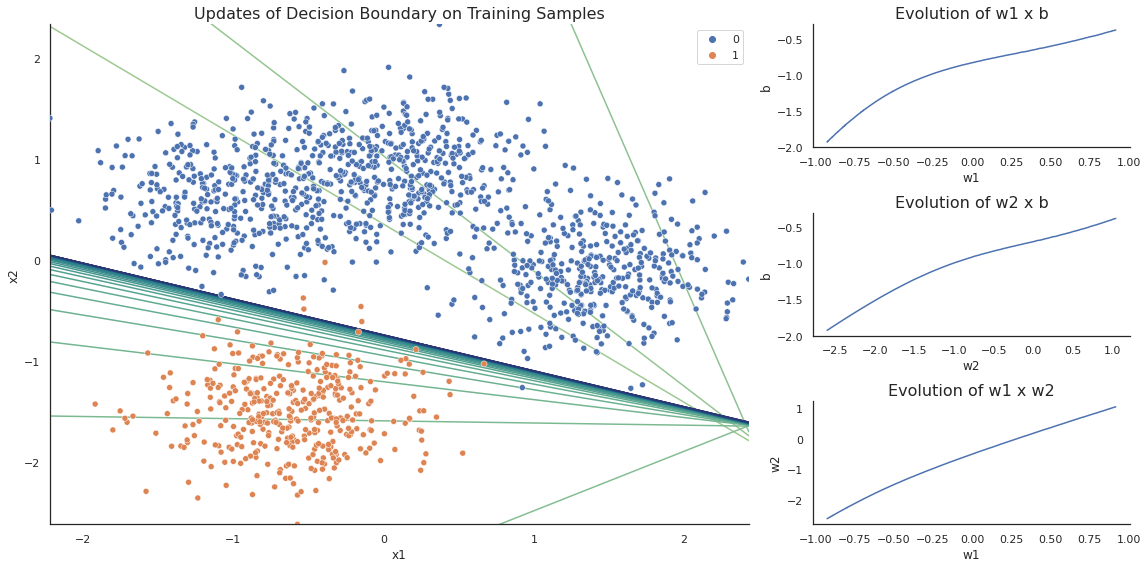

### TRAINING FOR CLASS "Class 4" ###
[INFO] iteration=1/3200, loss=1.1742999
[INFO] iteration=100/3200, loss=0.8511306
[INFO] iteration=200/3200, loss=0.7128679
[INFO] iteration=300/3200, loss=0.5882555
[INFO] iteration=400/3200, loss=0.4976818
[INFO] iteration=500/3200, loss=0.4580156
[INFO] iteration=600/3200, loss=0.4259304
[INFO] iteration=700/3200, loss=0.3593451
[INFO] iteration=800/3200, loss=0.4007494
[INFO] iteration=900/3200, loss=0.4103644
[INFO] iteration=1000/3200, loss=0.3225496
[INFO] iteration=1100/3200, loss=0.4051653
[INFO] iteration=1200/3200, loss=0.3006346
[INFO] iteration=1300/3200, loss=0.2922719
[INFO] iteration=1400/3200, loss=0.3031840
[INFO] iteration=1500/3200, loss=0.3093720
[INFO] iteration=1600/3200, loss=0.2733679
[INFO] iteration=1700/3200, loss=0.2814740
[INFO] iteration=1800/3200, loss=0.3198157
[INFO] iteration=1900/3200, loss=0.3446225
[INFO] iteration=2000/3200, loss=0.2914709
[INFO] iteration=2100/3200, loss=0.2735079
[INFO] iteration=2200/3200, l

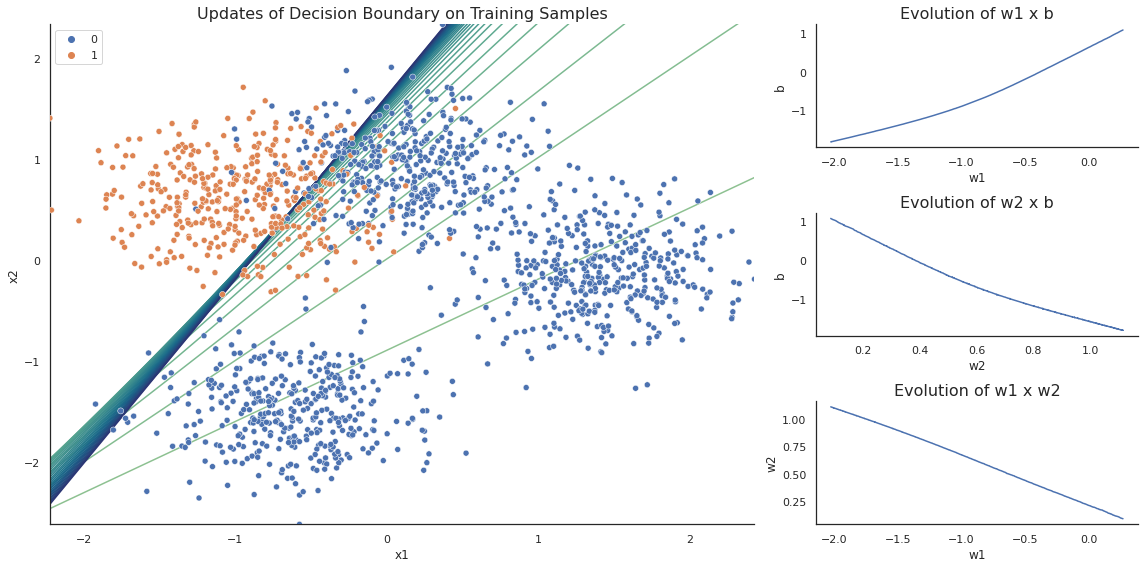

LogisticRegression(n_epochs=200, optimizer='minibatch', verbose=100)

In [16]:
clf = LogisticRegression(optimizer='minibatch', verbose=100)
clf.fit(X_train, y_train)

#### Using Stochastic gradient descent

### TRAINING FOR CLASS "Class 1" ###
[INFO] iteration=1/3200, loss=0.6922532
[INFO] iteration=100/3200, loss=0.5994309
[INFO] iteration=200/3200, loss=0.5469645
[INFO] iteration=300/3200, loss=0.5996936
[INFO] iteration=400/3200, loss=0.7298278
[INFO] iteration=500/3200, loss=0.7511287
[INFO] iteration=600/3200, loss=0.6262234
[INFO] iteration=700/3200, loss=0.8477558
[INFO] iteration=800/3200, loss=0.2869452
[INFO] iteration=900/3200, loss=0.8381858
[INFO] iteration=1000/3200, loss=0.0295892
[INFO] iteration=1100/3200, loss=0.4469072
[INFO] iteration=1200/3200, loss=0.4142378
[INFO] iteration=1300/3200, loss=1.1995505
[INFO] iteration=1400/3200, loss=0.3442585
[INFO] iteration=1500/3200, loss=0.0170920
[INFO] iteration=1600/3200, loss=0.4500573
[INFO] iteration=1700/3200, loss=0.5153558
[INFO] iteration=1800/3200, loss=0.2942598
[INFO] iteration=1900/3200, loss=0.7808678
[INFO] iteration=2000/3200, loss=0.5550246
[INFO] iteration=2100/3200, loss=0.1914261
[INFO] iteration=2200/3200, l

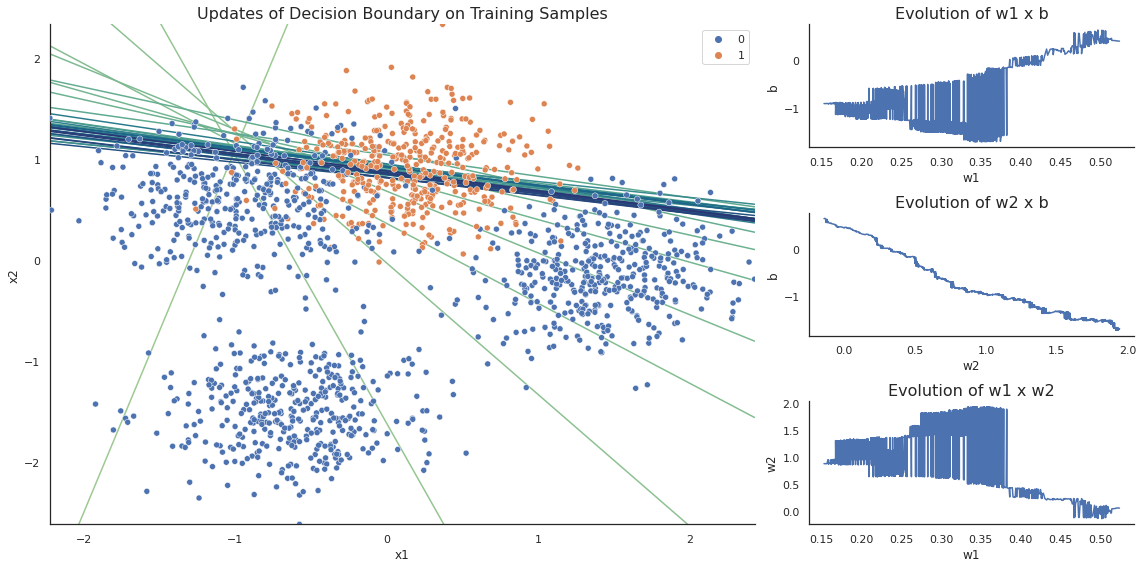

### TRAINING FOR CLASS "Class 2" ###
[INFO] iteration=1/3200, loss=0.0848681
[INFO] iteration=100/3200, loss=0.0057030
[INFO] iteration=200/3200, loss=0.0178611
[INFO] iteration=300/3200, loss=0.0025429
[INFO] iteration=400/3200, loss=0.1064936
[INFO] iteration=500/3200, loss=0.6018499
[INFO] iteration=600/3200, loss=0.1473438
[INFO] iteration=700/3200, loss=0.0376819
[INFO] iteration=800/3200, loss=0.0840388
[INFO] iteration=900/3200, loss=0.0496232
[INFO] iteration=1000/3200, loss=0.1108449
[INFO] iteration=1100/3200, loss=0.3342368
[INFO] iteration=1200/3200, loss=1.6601481
[INFO] iteration=1300/3200, loss=0.1339925
[INFO] iteration=1400/3200, loss=0.1740219
[INFO] iteration=1500/3200, loss=0.0173151
[INFO] iteration=1600/3200, loss=0.0015640
[INFO] iteration=1700/3200, loss=0.0195011
[INFO] iteration=1800/3200, loss=0.1895898
[INFO] iteration=1900/3200, loss=0.0622916
[INFO] iteration=2000/3200, loss=0.0005470
[INFO] iteration=2100/3200, loss=0.0247093
[INFO] iteration=2200/3200, l

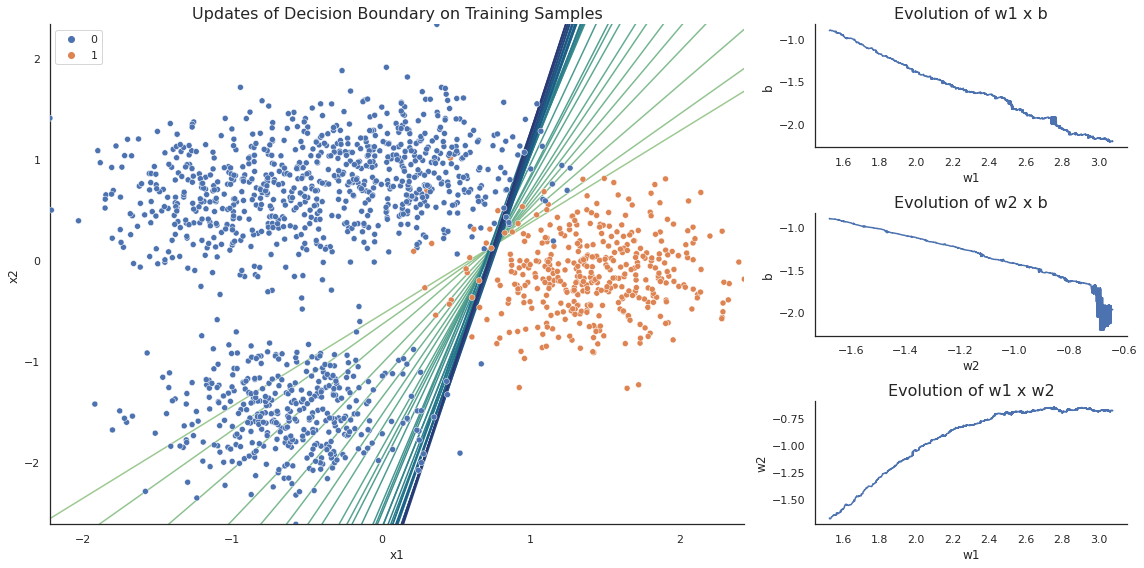

### TRAINING FOR CLASS "Class 3" ###
[INFO] iteration=1/3200, loss=4.8407410
[INFO] iteration=100/3200, loss=2.2655262
[INFO] iteration=200/3200, loss=0.9481264
[INFO] iteration=300/3200, loss=0.0394350
[INFO] iteration=400/3200, loss=1.4091195
[INFO] iteration=500/3200, loss=0.7192873
[INFO] iteration=600/3200, loss=0.6598106
[INFO] iteration=700/3200, loss=0.4726254
[INFO] iteration=800/3200, loss=0.1551309
[INFO] iteration=900/3200, loss=0.0396887
[INFO] iteration=1000/3200, loss=0.3187922
[INFO] iteration=1100/3200, loss=0.0853985
[INFO] iteration=1200/3200, loss=0.1390557
[INFO] iteration=1300/3200, loss=0.0649894
[INFO] iteration=1400/3200, loss=0.0169383
[INFO] iteration=1500/3200, loss=0.0308012
[INFO] iteration=1600/3200, loss=0.1138864
[INFO] iteration=1700/3200, loss=0.2918761
[INFO] iteration=1800/3200, loss=0.2412413
[INFO] iteration=1900/3200, loss=0.1714918
[INFO] iteration=2000/3200, loss=0.1392631
[INFO] iteration=2100/3200, loss=0.0900932
[INFO] iteration=2200/3200, l

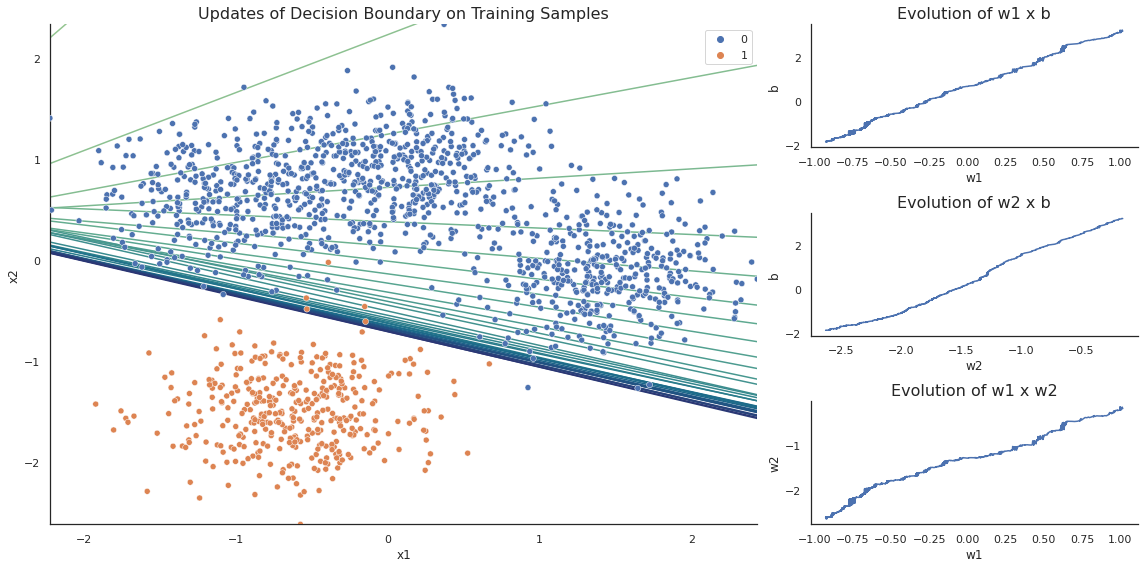

### TRAINING FOR CLASS "Class 4" ###
[INFO] iteration=1/3200, loss=2.0529843
[INFO] iteration=100/3200, loss=0.2378116
[INFO] iteration=200/3200, loss=1.9384069
[INFO] iteration=300/3200, loss=1.4596927
[INFO] iteration=400/3200, loss=1.1631916
[INFO] iteration=500/3200, loss=0.1435105
[INFO] iteration=600/3200, loss=0.9206653
[INFO] iteration=700/3200, loss=0.5299590
[INFO] iteration=800/3200, loss=0.1358964
[INFO] iteration=900/3200, loss=0.0874073
[INFO] iteration=1000/3200, loss=0.3200971
[INFO] iteration=1100/3200, loss=0.4364740
[INFO] iteration=1200/3200, loss=1.3369855
[INFO] iteration=1300/3200, loss=0.0552274
[INFO] iteration=1400/3200, loss=0.0640334
[INFO] iteration=1500/3200, loss=0.0501828
[INFO] iteration=1600/3200, loss=0.5199618
[INFO] iteration=1700/3200, loss=0.0515043
[INFO] iteration=1800/3200, loss=0.0403293
[INFO] iteration=1900/3200, loss=0.0466199
[INFO] iteration=2000/3200, loss=0.1325547
[INFO] iteration=2100/3200, loss=0.0963224
[INFO] iteration=2200/3200, l

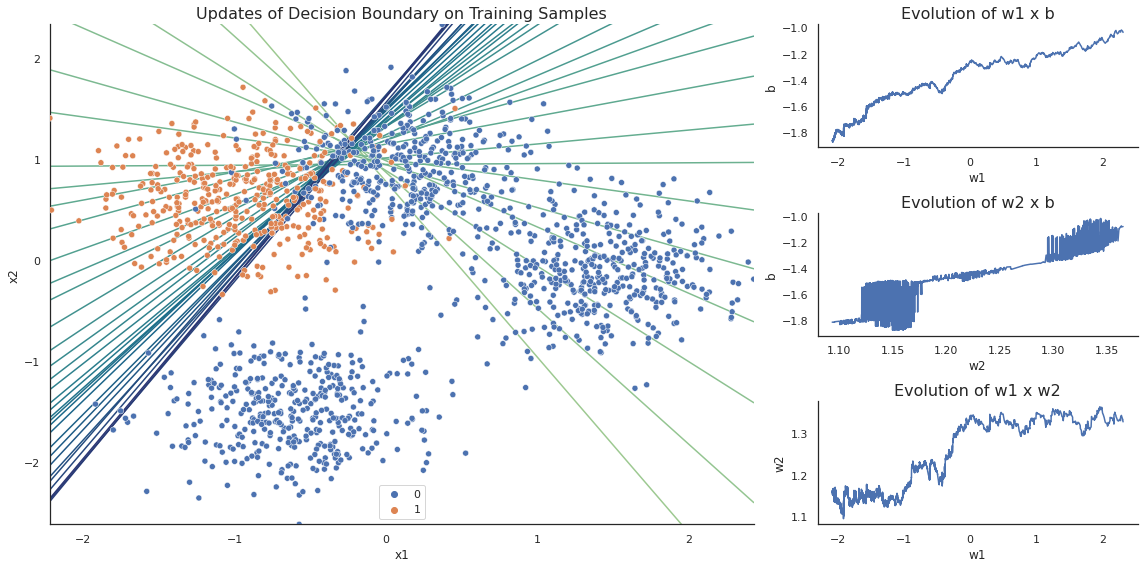

LogisticRegression(n_epochs=2, optimizer='stochastic', verbose=100)

In [17]:
clf = LogisticRegression(optimizer='stochastic', verbose=100)
clf.fit(X_train, y_train)

#### Visualizing the Decision Boundary

$w_1x_1 + w_2x_2 + b = 0$

$x_2 = -(b + w_1x_1)/w_2$

In [18]:
def plot_boundaries(X, y, clf, ax=None):
    if ax == None:
        _, ax = plt.subplots(figsize=(10, 8))
    
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, hue_order=clf.classes_, ax=ax)
    
    colors = sns.color_palette()
    for i, (w1, w2), b in zip(range(clf.n_classes_), clf.coef_, clf.intercept_):
        x1_decision_line = np.array([X[:, 0].min(), X[:, 0].max()])
        x2_decision_line = -(b + (w1 * x1_decision_line)) / w2
        sns.lineplot(x=x1_decision_line, y=x2_decision_line, color=colors[i], ax=ax)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(X_train[:,0].min() - 0.5, X_train[:,0].max() + 0.5)
    ax.set_ylim(X_train[:,1].min() - 0.5, X_train[:,1].max() + 0.5)
    
    return ax

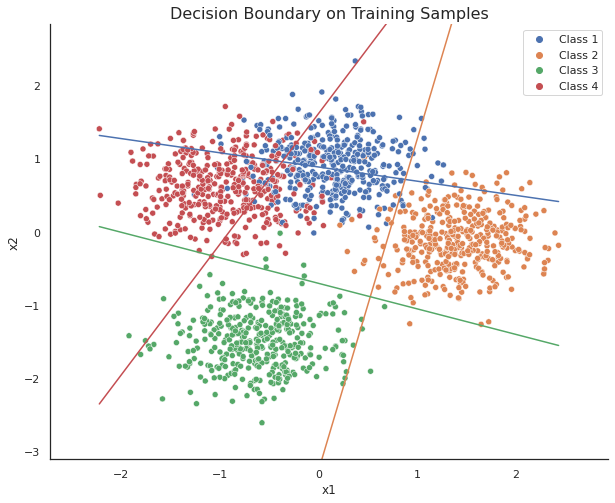

In [19]:
ax = plot_boundaries(X_train, y_train, clf)
plt.title('Decision Boundary on Training Samples')
plt.show()

#### Prediction

In [20]:
y_test_pred = clf.predict(X_test)

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

     Class 1       0.92      0.84      0.88        87
     Class 2       0.94      0.99      0.97       103
     Class 3       1.00      0.99      1.00       112
     Class 4       0.91      0.95      0.93        98

    accuracy                           0.95       400
   macro avg       0.95      0.94      0.94       400
weighted avg       0.95      0.95      0.95       400



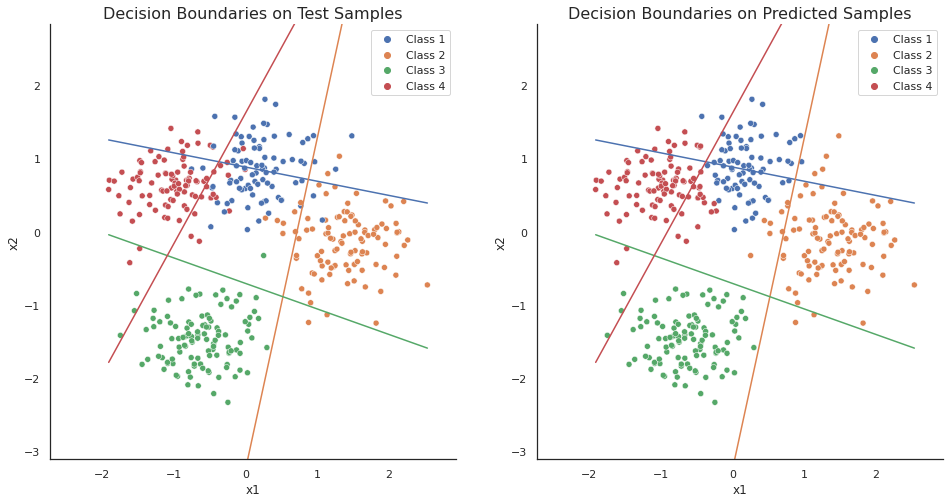

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

plot_boundaries(X_test, y_test, clf, ax=ax[0])
plot_boundaries(X_test, y_test_pred, clf, ax=ax[1])
ax[0].set_title('Decision Boundaries on Test Samples')
ax[1].set_title('Decision Boundaries on Predicted Samples')
plt.show()

### Fitting a binary problem

#### Creating fake data

In [23]:
X, y = make_blobs(n_samples=2000, n_features=2, centers=2, cluster_std=2.5, random_state=42)

y = np.array([f'Class {c + 1}' for c in y])

labels = np.sort(np.unique(y))

print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')
print(f'Labels: {labels}')

X.shape: (2000, 2)
y.shape: (2000,)
Labels: ['Class 1' 'Class 2']


In [24]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (1600, 2)
y_train.shape = (1600,)
X_test.shape = (400, 2)
y_test.shape = (400,)


In [25]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

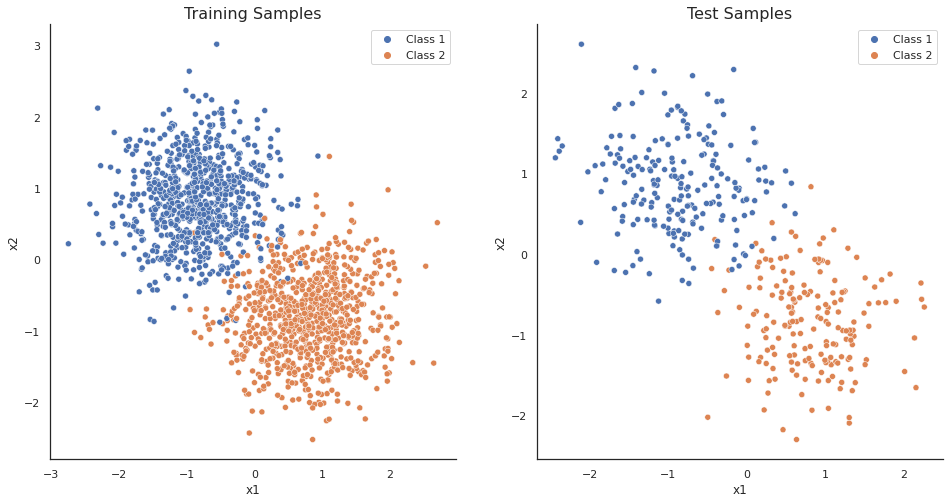

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, hue_order=labels, ax=ax[0])
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, hue_order=labels, ax=ax[1])

ax[0].set(xlabel='x1', ylabel='x2', title='Training Samples')
ax[1].set(xlabel='x1', ylabel='x2', title='Test Samples')

plt.show()

#### Using batch gradient descent

[INFO] iteration=1/1000, loss=0.5175983
[INFO] iteration=100/1000, loss=0.3785526
[INFO] iteration=200/1000, loss=0.3015709
[INFO] iteration=300/1000, loss=0.2545125
[INFO] iteration=400/1000, loss=0.2230317
[INFO] iteration=500/1000, loss=0.2005161
[INFO] iteration=600/1000, loss=0.1835908
[INFO] iteration=700/1000, loss=0.1703767
[INFO] iteration=800/1000, loss=0.1597509
[INFO] iteration=900/1000, loss=0.1510030
[INFO] iteration=1000/1000, loss=0.1436621

Final loss: 0.1436620664341339

Mean loss: 0.23371720808202093 +- 0.09030598042560284


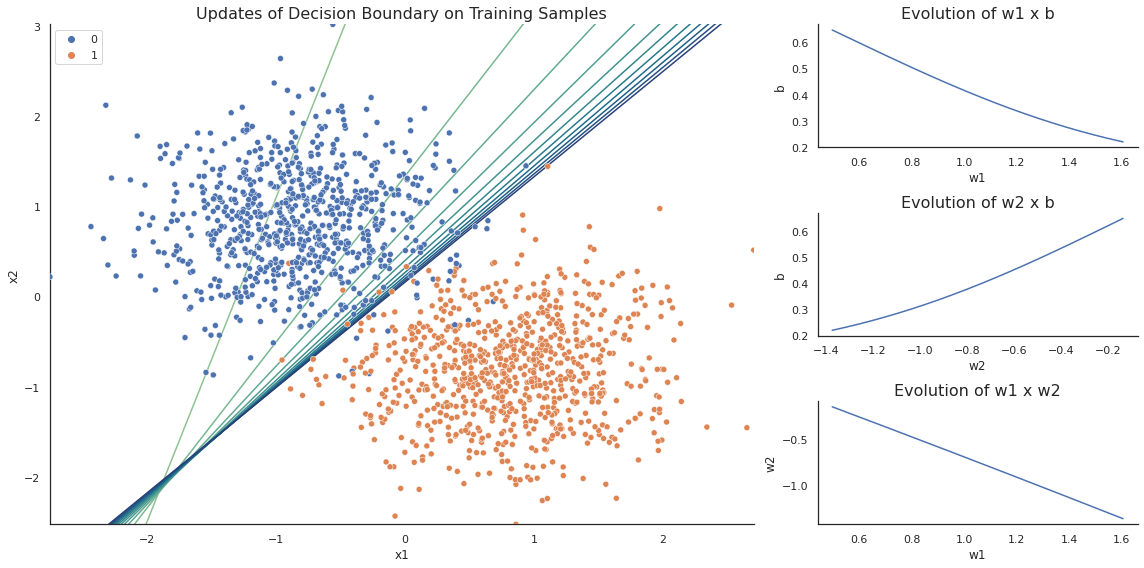

LogisticRegression(n_epochs=1000, verbose=100)

In [27]:
clf = LogisticRegression(verbose=100)
clf.fit(X_train, y_train)

In [28]:
print(f"""
Fitted parameters:
==================
  - # of classes [clf.n_classes_]: {clf.n_classes_}
  - Classes [clf.classes_]: {clf.classes_}
  - Multilabel? [clf.multilabel_]: {clf.multilabel_}
  - # of features [clf.n_features_in_]: {clf.n_features_in_}
  
  - Shape of biases array (1,): {clf.intercept_.shape}
  - Biases array [clf.intercept_]: {clf.intercept_}
  
  - Shape of weights matrix (1, n_features): {clf.coef_.shape}
  - Weights matrix [clf.coef_]: {clf.coef_}
""")


Fitted parameters:
  - # of classes [clf.n_classes_]: 2
  - Classes [clf.classes_]: ['Class 1' 'Class 2']
  - Multilabel? [clf.multilabel_]: False
  - # of features [clf.n_features_in_]: 2
  
  - Shape of biases array (1,): (1,)
  - Biases array [clf.intercept_]: [0.22013806]
  
  - Shape of weights matrix (1, n_features): (1, 2)
  - Weights matrix [clf.coef_]: [[ 1.60613775 -1.37464668]]



#### Using Minibatch gradient descent

[INFO] iteration=1/3200, loss=0.5147475
[INFO] iteration=100/3200, loss=0.3918284
[INFO] iteration=200/3200, loss=0.3053243
[INFO] iteration=300/3200, loss=0.2390952
[INFO] iteration=400/3200, loss=0.2094104
[INFO] iteration=500/3200, loss=0.1956228
[INFO] iteration=600/3200, loss=0.1887908
[INFO] iteration=700/3200, loss=0.2075895
[INFO] iteration=800/3200, loss=0.1317776
[INFO] iteration=900/3200, loss=0.1568248
[INFO] iteration=1000/3200, loss=0.1325710
[INFO] iteration=1100/3200, loss=0.1433334
[INFO] iteration=1200/3200, loss=0.1286272
[INFO] iteration=1300/3200, loss=0.0933364
[INFO] iteration=1400/3200, loss=0.1400500
[INFO] iteration=1500/3200, loss=0.1100601
[INFO] iteration=1600/3200, loss=0.1075711
[INFO] iteration=1700/3200, loss=0.1245165
[INFO] iteration=1800/3200, loss=0.1405202
[INFO] iteration=1900/3200, loss=0.1055866
[INFO] iteration=2000/3200, loss=0.0714877
[INFO] iteration=2100/3200, loss=0.0948914
[INFO] iteration=2200/3200, loss=0.0780309
[INFO] iteration=2300/3

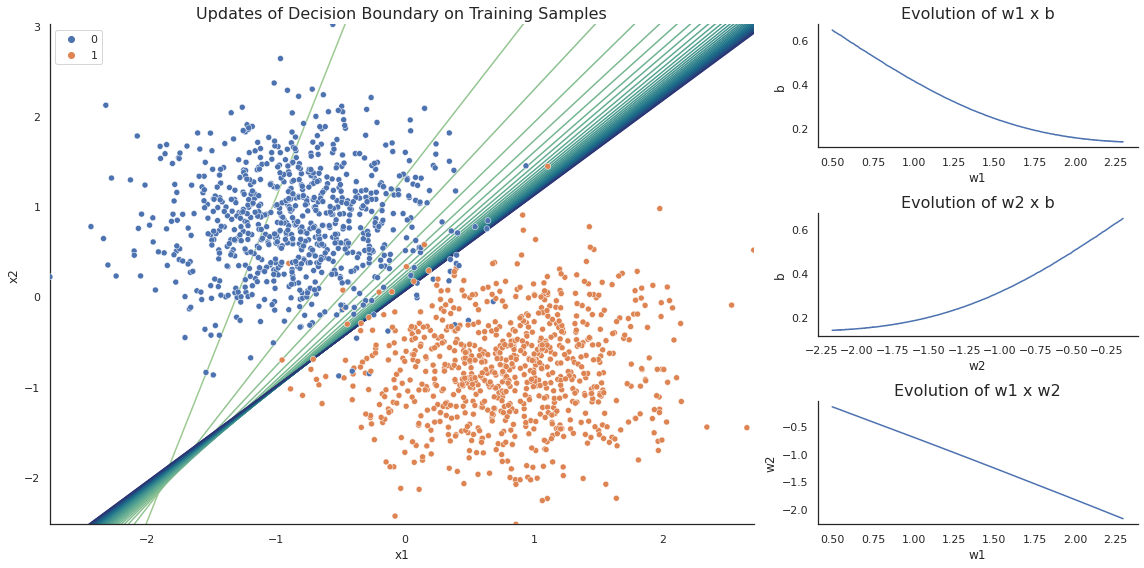

LogisticRegression(n_epochs=200, optimizer='minibatch', verbose=100)

In [29]:
clf = LogisticRegression(optimizer='minibatch', verbose=100)
clf.fit(X_train, y_train)

#### Using Stochastic gradient descent

[INFO] iteration=1/3200, loss=0.6700828
[INFO] iteration=100/3200, loss=0.7172156
[INFO] iteration=200/3200, loss=0.2169946
[INFO] iteration=300/3200, loss=0.0886786
[INFO] iteration=400/3200, loss=0.0780854
[INFO] iteration=500/3200, loss=0.1071050
[INFO] iteration=600/3200, loss=0.3535669
[INFO] iteration=700/3200, loss=0.0687437
[INFO] iteration=800/3200, loss=0.1055914
[INFO] iteration=900/3200, loss=0.0451777
[INFO] iteration=1000/3200, loss=0.0956900
[INFO] iteration=1100/3200, loss=0.1682538
[INFO] iteration=1200/3200, loss=0.0216105
[INFO] iteration=1300/3200, loss=0.0309143
[INFO] iteration=1400/3200, loss=0.3647159
[INFO] iteration=1500/3200, loss=0.1322037
[INFO] iteration=1600/3200, loss=0.0266302
[INFO] iteration=1700/3200, loss=0.1011856
[INFO] iteration=1800/3200, loss=0.1659242
[INFO] iteration=1900/3200, loss=0.0074567
[INFO] iteration=2000/3200, loss=0.1342504
[INFO] iteration=2100/3200, loss=0.0110435
[INFO] iteration=2200/3200, loss=0.1241768
[INFO] iteration=2300/3

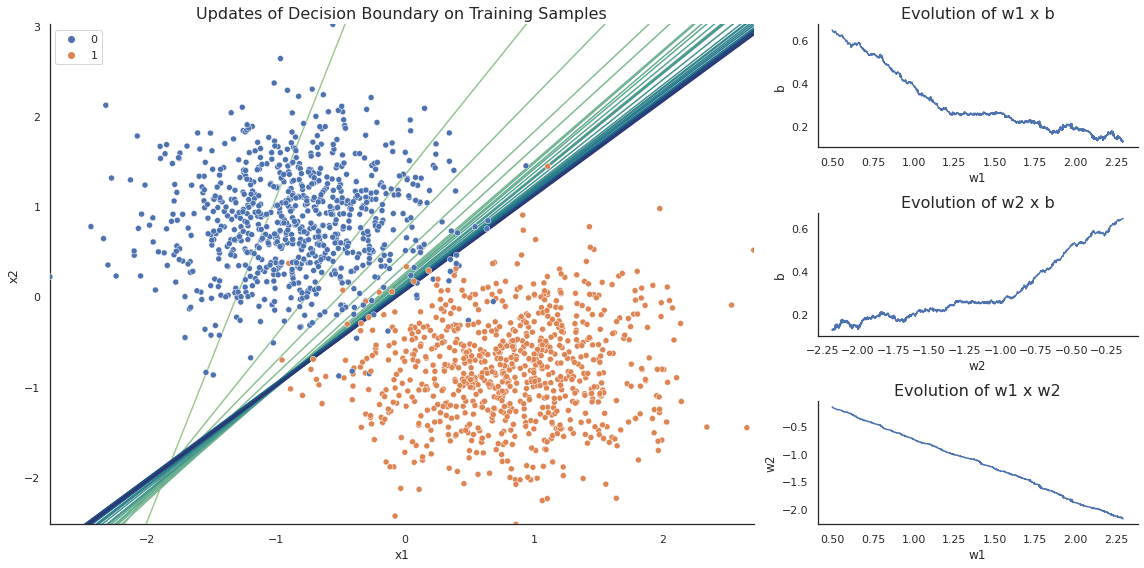

LogisticRegression(n_epochs=2, optimizer='stochastic', verbose=100)

In [30]:
clf = LogisticRegression(optimizer='stochastic', verbose=100)
clf.fit(X_train, y_train)

#### Visualizing the Decision Boundary

$w_1x_1 + w_2x_2 + b = 0$

$x_2 = -(b + w_1x_1)/w_2$

In [31]:
def plot_boundaries(X, y, clf, ax=None):
    if ax == None:
        _, ax = plt.subplots(figsize=(10, 8))
    
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, hue_order=clf.classes_, ax=ax)
    
    colors = sns.color_palette()
    for i, (w1, w2), b in zip(range(clf.n_classes_), clf.coef_, clf.intercept_):
        x1_decision_line = np.array([X[:, 0].min(), X[:, 0].max()])
        x2_decision_line = -(b + (w1 * x1_decision_line)) / w2
        sns.lineplot(x=x1_decision_line, y=x2_decision_line, color=colors[i], ax=ax)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(X_train[:,0].min() - 0.5, X_train[:,0].max() + 0.5)
    ax.set_ylim(X_train[:,1].min() - 0.5, X_train[:,1].max() + 0.5)
    
    return ax

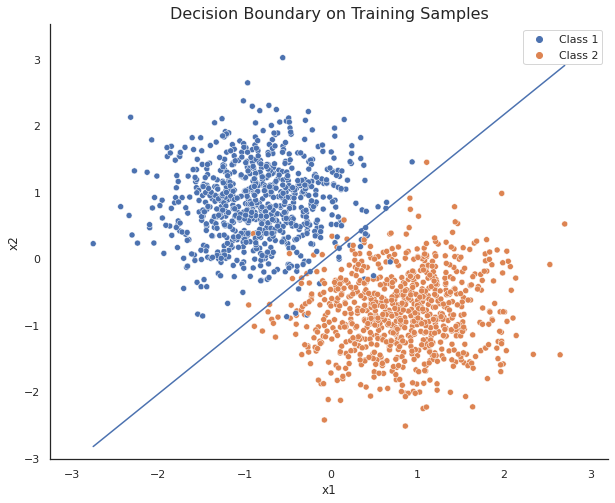

In [32]:
ax = plot_boundaries(X_train, y_train, clf)
plt.title('Decision Boundary on Training Samples')
plt.show()

#### Prediction

In [33]:
y_test_pred = clf.predict(X_test)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

     Class 1       0.99      0.97      0.98       216
     Class 2       0.96      0.99      0.98       184

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



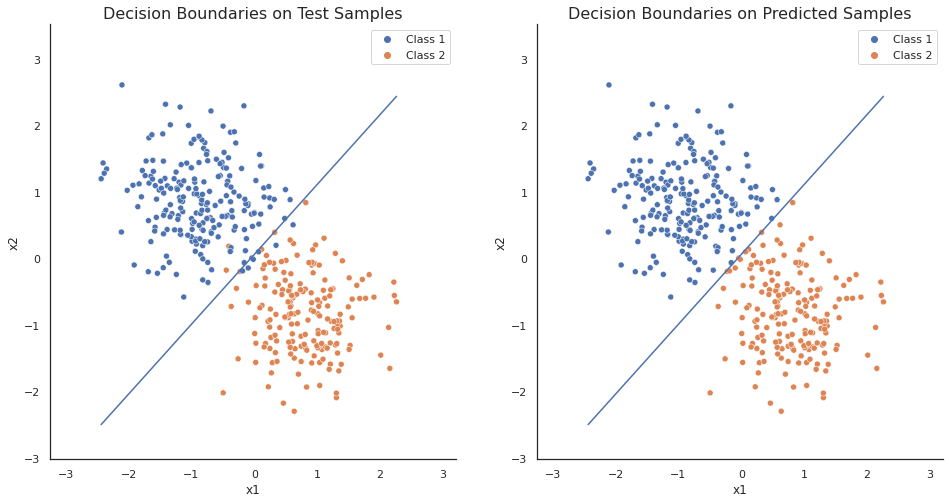

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

plot_boundaries(X_test, y_test, clf, ax=ax[0])
plot_boundaries(X_test, y_test_pred, clf, ax=ax[1])
ax[0].set_title('Decision Boundaries on Test Samples')
ax[1].set_title('Decision Boundaries on Predicted Samples')
plt.show()